# SYDE 556/750 --- Assignment 3
**Student ID: 00000000**

*Note:* Please include your numerical student ID only, do *not* include your name.

*Note:* Refer to the [PDF](https://github.com/tcstewar/syde556-f21/raw/master/assignments/assignment_03/syde556_assignment_03.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.

In [551]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
import matplotlib.pyplot as plt

# Fix the numpy random seed for reproducible results
np.random.seed(116945)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 1. Decoding from a population

**a) Tuning curves.** Plot the tuning curves (firing rate of each neuron for different $x$ values between $-2$ and $2$).

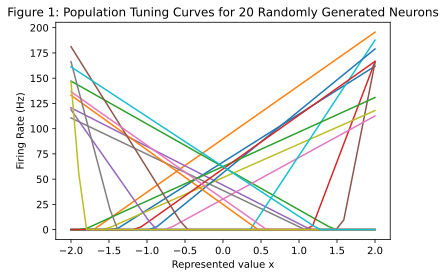

In [552]:
tref = 0.002
trc = 0.02
# First, generate random values for amax and xi using the constraints from the problem
num_neurons = 20
linespace = np.linspace(-2, 2, num=40)

def generate_a_maxs(num_neurons):
    # 100 Hz < Frequency < 200 Hz
    freq_min = 100
    freq_max = 200
    a_maxs = np.random.uniform(freq_min, freq_max, num_neurons)
    return a_maxs

def generate_intercepts(num_neurons):
    #  -2 < Intercept < 2
    intercept_min = -2
    intercept_max = 2
    intercepts = np.random.uniform(intercept_min,intercept_max, num_neurons)
    return intercepts

def find_gain(amax, encoder, intercept):
    return (amax - 1) / (2 - encoder * intercept)

def find_j_bias(intercept, encoder, a):
    return 1 - a * intercept * encoder

def RMSE(size, X, X_hat):
    sum = 0
    for i in range (size):
        sum = sum + np.square(X[i]-X_hat[i])
    rmse = np.sqrt(sum) / size
    return rmse

class LIFNeuron: 
    def __init__(self, index, a_maxs, intercepts):
        self.index = index
        self.encoder = np.random.choice([-1,1])
        self.amax = a_maxs[index]
        self.intercept = intercepts[index]
        self.a = find_gain(self.amax, self.encoder, self.intercept)
        self.j_bias = find_j_bias(self.intercept, self.encoder, self.a)
        self.slope = []

    def find_firing_rate(self, linespace):
        for x in linespace:
            slope = max((self.a * np.dot(x,self.encoder)) + self.j_bias, 0)
            self.slope.append(slope)
            
# Create neurons
neurons = []
a_maxs = generate_a_maxs(num_neurons)
intercepts = generate_intercepts(num_neurons)

for i in range (num_neurons):
    neurons.append(LIFNeuron(i, a_maxs, intercepts))

# Find neuron firing rates
for i in range (num_neurons):
    neurons[i].find_firing_rate(linespace)

for i in range (num_neurons):
    plt.plot(linespace, neurons[i].slope)
    plt.title("Figure 1: Population Tuning Curves for 20 Randomly Generated Neurons")
    plt.xlabel("Represented value x")
    plt.ylabel("Firing Rate (Hz)")

**b) Decoder and error computation.** Compute the decoders and plot $(x-\hat{x})$. When computing decoders, take into account noise ($\sigma=0.1 \cdot 200\,\mathrm{Hz}$). When computing $\hat{x}$, add random Gaussian noise with $\sigma=0.1 \cdot 200\,\mathrm{Hz}$ to the activity. Report the Root Mean-Squared Error (RMSE).

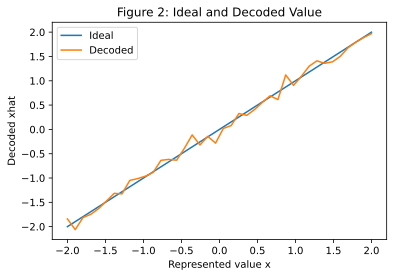

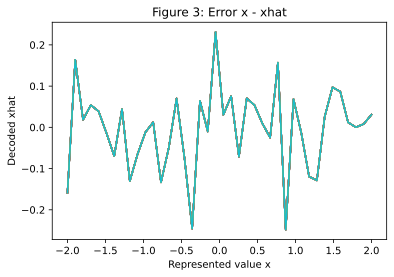

 RMSE:  0.09925459783471338


In [558]:
activities = []
inputs = []

for i in range (num_neurons):
    activities.append(neurons[i].slope)
    inputs.append(linespace)

A = np.array(activities)
X = np.array(inputs)

# generate random Gaussian noise
mean = 0
max_std_dev = 20
noise = np.random.normal(mean, max_std_dev, np.shape(A)) 

# add noise and compute decoders
A_noisy =  A + noise
D = np.linalg.lstsq((A_noisy).T, X.T, rcond=None)[0].T[0]
X_hat = np.dot(D, A_noisy)

error = np.subtract(X, X_hat)

plt.plot(linespace, linespace)
plt.plot(linespace, X_hat)

plt.title("Figure 2: Ideal and Decoded Value")
plt.xlabel("Represented value x")
plt.ylabel("Decoded xhat")
plt.legend(['Ideal', 'Decoded'])
plt.show()

plt.title("Figure 3: Error x - xhat")
plt.xlabel("Represented value x")
plt.ylabel("Decoded xhat")
plt.plot(linespace, error.T)
plt.show()

rmse = RMSE(num_neurons, linespace, X_hat)
print(" RMSE: ", rmse)

# 2. Decoding from two spiking neurons

**a) Synaptic filter.** Plot the post-synaptic current
		$$
			h(t)= \begin{cases}
				0 & \text{if } t < 0 \,, \\
				\frac{e^{-t/\tau}}{\int_0^\infty e^{-t'/\tau} \mathrm{d}t'} & \text{otherwise} \,.
			\end{cases}
		$$

In [ ]:
def calculate_rms(x_t):
    rms = np.sqrt(np.mean(np.square(x_t)))
    return rms

def rescale_rms(x_t, rms):
    real_rms = calculate_rms(x_t)
    rescaled_x_t = []
    for e in x_t:
        newval = e * rms / real_rms
        rescaled_x_t.append(newval)
    return rescaled_x_t
    
def calculate_power_spectrum(X_w):
    return (np.absolute(X_w))[0]

def generate_signal(T, dt, rms, limit, seed):
    np.random.seed(seed)

    timeline = np.arange(0, T, dt)
    N = len(timeline)
    frequencies = np.fft.fftfreq(N, dt)
    F = len(frequencies)   

    # generate signal
    X_w = np.array(np.zeros(F)).tolist()
    
    for x, y in enumerate(frequencies):
        if (X_w[x] == 0) & (abs(y) <= limit):
            # Generate random a and b values
            a = np.random.normal()
            b = np.random.normal()

            # Add the new value to the array
            X_w[x]= np.complex(a + (b * 1j))

            # Check if the conjugate of a + jb exists in already in X(w)
            X_w_array = np.array(X_w)
            if (np.complex(a - (b * 1j)) not in X_w_array):
                X_w[-x]= np.complex(a - b * 1j)

    # get time domain signal         
    x_t = np.real(np.fft.ifft(X_w))

    # rescale 
    x_t = rescale_rms(x_t, rms)

    # find new X(w) from rescaled x(t)
    X_t = np.fft.fft(x_t)

    return X_w, x_t, timeline, frequencies

def synaptic_filter(tau, dt, ms):
    t_h = np.arange(ms) * dt - 0.5
    h = (1 / tau) * np.exp(-t_h / tau)
    h[np.where(t_h < 0)] = 0
    h = h / np.linalg.norm(h, 1)
    return h, t_h

def find_voltage(trc, J, V, dt):
    return V + (dt*(1 / trc)*(J - V))
    
def find_encoded_neuron(a, e, x, j_bias):
    return (a*x*e) + j_bias
    
def find_lif(a, x, e, j_bias):
    J = find_encoded_neuron(a, e, x, j_bias)
    return 1 / (tref - trc * np.log(1 - 1 / J)) if J > 1 else 0 

class SpikingNeuron: 
    def __init__(self, index, alpha, tref, trc, intercept, j_bias, encoder):
        self.index = index
        self.encoder = encoder
        self.tref = tref
        self.trc = trc
        self.intercept = intercept
        self.a = alpha
        self.j_bias = j_bias
        self.spikevals = []
        self.spike_count = 0


    def find_spike_train(self, X, dt, vth, v0):
        # define voltage
        V = v0

        # set refractory period to 0 cycles
        # this is an integer that tracks how many cycles of refractory period need to be done
        ref = 0

        # create empty array for spikes
        self.spikevals= np.array(np.zeros(len(X))).T

        for j in range(len(X)): 
            
            # update voltage and current    
            J = find_encoded_neuron(self.a, self.encoder, X[j], self.j_bias)
            V = find_voltage(trc, J, V, dt)
            
            # refractory period
            if (ref > 0):
                V = v0
                # votage is always 0 in this period
                self.spikevals[j] = 0
                # reduce refractory length since we did one cycle
                ref = ref - 1

            # if the voltage goes negative, reset to 0
            elif ( V < v0 ):
                V = v0
                self.spikevals[j] = V

            # spike
            elif ( V >= vth ):

                # increment the spike counter
                self.spike_count = self.spike_count + 1

                # log the spike voltage
                self.spikevals[j] = V
                
                # start refractory period
                # the refractory period is the refractory length divided by the timestep
                # eg for tref 2ms and dt 1 ms, the ref = 2 cycles
                ref = tref/dt

        return self.spikevals, self.spike_count


C:\Users\thecu\AppData\Local\Temp\ipykernel_16080\3232307624.py:34: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_w[x]= np.complex(a + (b * 1j))
C:\Users\thecu\AppData\Local\Temp\ipykernel_16080\3232307624.py:38: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (np.complex(a - (b * 1j)) not in X_w_array):
C:\Users\thec

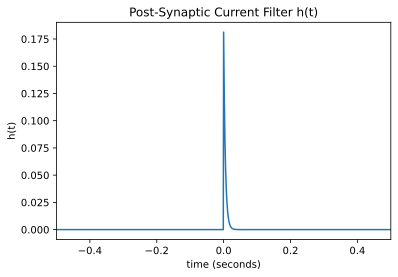

In [ ]:
alpha_q2 = 0
jbias_q2 = 0

for neuron in neurons:
    if neuron.slope < [20, 50] or neuron.slope > [20, 50]:
        alpha_q2 = neuron.a
        jbias_q2 = neuron.j_bias

intercepts_q2 = generate_intercepts(2)
a_maxs_q2 = generate_a_maxs(2)

neuron_1 = SpikingNeuron(0, alpha_q2, tref, trc, intercepts_q2[0], jbias_q2, 1)
neuron_2 = SpikingNeuron(1, alpha_q2, tref, trc, intercepts_q2[1], jbias_q2, -1)


T = 1 # the length of the signal in seconds
ms = T*1000
dt = 0.001 # the time step in seconds
rms = 0.5 # the root mean square power (RMS) level of the signal
tau = 0.005


# generate the three signals with varying limits
X_w_0, x_t_0, timeline_0, frequencies_0 = generate_signal(1, dt, rms, 5, np.random.seed())

h, t_h = synaptic_filter(tau, dt, ms)

plt.figure()
plt.title("Post-Synaptic Current Filter h(t)")
plt.xlabel("time (seconds)")
plt.ylabel("h(t)")
plt.plot(t_h, h)
plt.xlim([-0.5, 0.5])
plt.show()

**b) Decoding using a synaptic filter.** Plot the original signal $x(t)$, the spikes, and the decoded $\hat{x}(t)$ all on the same graph.

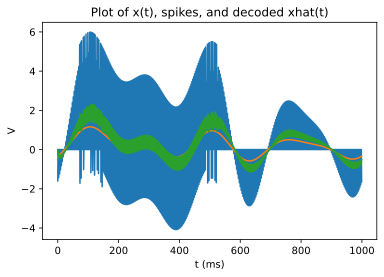

In [ ]:
# generate spike train
spikevals, spike_count = neuron_1.find_spike_train(x_t_0, dt, 1, 0)
spikevals2, spike_count2 = neuron_2.find_spike_train(x_t_0, dt, 1, 0)
spikes =  spikevals - spikevals2
xhat = np.convolve(spikes, h, mode="same")[: len(t_h)]

plt.figure()
plt.title("Plot of x(t), spikes, and decoded xhat(t)")
plt.xlabel("t (ms)")
plt.ylabel("V")
plt.plot(spikes)
plt.plot(x_t_0)
plt.plot(xhat)




plt.show()

**c) Error analysis.** Compute the RMSE of the decoding.

In [554]:
rmse_q2 = RMSE(1000, x_t_0, xhat)
print(rmse_q2)


0.3715135145380488


# 3. Decoding from many neurons

**a) Exploring the error for an increasing neuron count.** Plot the Root Mean-Squared Error as the number of neurons increases, on a log-log plot. Try $16$ neurons, $16$ neurons, $32$, $64$, $128$, up to $256$. For the RMSE for a particular number of neurons, average over at least $5$ randomly generated groups of neurons. For each group of neurons, randomly generate the signal $x(t)$. Use the same parameters as in question 2.

In [557]:
class SpikingNeuron2: 
    def __init__(self, index, tref, trc, intercept, a_max):
        self.index = index
        self.tref = tref
        self.trc = trc
        self.intercept = intercept
        self.spikevals = []
        self.spike_count = 0
        self.encoder = np.random.choice([-1,1])
        self.amax = a_max
        self.a = find_gain(self.amax, self.encoder, self.intercept)
        self.j_bias = find_j_bias(self.intercept, self.encoder, self.a)

    def find_spike_train(self, X, dt, vth, v0):
        # define voltage
        V = v0

        # set refractory period to 0 cycles
        # this is an integer that tracks how many cycles of refractory period need to be done
        ref = 0

        # create empty array for spikes
        self.spikevals= np.array(np.zeros(len(X))).T

        for j in range(len(X)): 
            
            # update voltage and current    
            J = find_encoded_neuron(self.a, self.encoder, X[j], self.j_bias)
            V = find_voltage(trc, J, V, dt)
            
            # refractory period
            if (ref > 0):
                V = v0
                # votage is always 0 in this period
                self.spikevals[j] = 0
                # reduce refractory length since we did one cycle
                ref = ref - 1

            # if the voltage goes negative, reset to 0
            elif ( V < v0 ):
                V = v0
                self.spikevals[j] = V

            # spike
            elif ( V >= vth ):

                # increment the spike counter
                self.spike_count = self.spike_count + 1

                # log the spike voltage
                self.spikevals[j] = V
                
                # start refractory period
                # the refractory period is the refractory length divided by the timestep
                # eg for tref 2ms and dt 1 ms, the ref = 2 cycles
                ref = tref/dt

        return self.spikevals, self.spike_count
        

rmses = []


# 8
# generate neurons
neurons_8 = []
X_w_8, x_t_8, timeline_8, frequencies_8 = generate_signal(1, dt, rms, 5, np.random.seed())
spikes8 = (0,0)
intercepts8 = generate_intercepts(8)
amaxs8 = generate_a_maxs(8)
for i in range(8):
    neurons_8.append(SpikingNeuron2(i+8, tref, trc, intercepts8[i], amaxs8[i]))
    # find firing rates
    spike_train, spike_count = neurons_8[i].find_spike_train(x_t_8, dt, 1, 0)
    if neurons_8[i].encoder == -1:
        spike_train = -spike_train
    spikes8 = spikes8 + neurons_8[i].find_spike_train(x_t_8, dt, 1, 0)
xhat_8 = np.convolve(spikes8, h, mode="same")[: len(t_h)]

 

#  16
neurons_16 = []
X_w_16, x_t_16, timeline_16, frequencies_16 = generate_signal(1, dt, rms, 5, np.random.seed())
spikes16 = (0,0)
intercepts16 = generate_intercepts(16)
amaxs16 = generate_a_maxs(16)
for i in range(16):
    neurons_16.append(SpikingNeuron2(i+16, tref, trc, intercepts16[i], amaxs16[i]))
    # find firing rates
    spike_train, spike_count = neurons_16[i].find_spike_train(x_t_16, dt, 1, 0)
    if neurons_16[i].encoder == -1:
        spike_train = -spike_train
    spikes16 = spikes16 + neurons_16[i].find_spike_train(x_t_16, dt, 1, 0)
xhat_16 = np.convolve(spikes16, h, mode="same")[: len(t_h)]


# 32
neurons_32 = []
X_w_32, x_t_32, timeline_32, frequencies_32 = generate_signal(1, dt, rms, 5, np.random.seed())
spikes32 = (0,0)
intercepts32 = generate_intercepts(32)
amaxs32 = generate_a_maxs(32)
for i in range(32):
    neurons_32.append(SpikingNeuron2(i+32, tref, trc, intercepts32[i], amaxs32[i]))
    # find firing rates
    spike_train, spike_count = neurons_32[i].find_spike_train(x_t_32, dt, 1, 0)
    if neurons_32[i].encoder == -1:
        spike_train = -spike_train
    spikes32 = spikes32 + neurons_32[i].find_spike_train(x_t_32, dt, 1, 0)
xhat_32 = np.convolve(spikes32, h, mode="same")[: len(t_h)]


# 64
# generate neurons
# find firing rates
# find rmse

# 128
# generate neurons
# find firing rates
# find rmse

# 256
# generate neurons
# find firing rates
# find rmse 

# plot
print(rmses)


C:\Users\thecu\AppData\Local\Temp\ipykernel_16080\3232307624.py:34: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_w[x]= np.complex(a + (b * 1j))
C:\Users\thecu\AppData\Local\Temp\ipykernel_16080\3232307624.py:38: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (np.complex(a - (b * 1j)) not in X_w_array):
C:\Users\thec

[array([21.32541754, 21.24141963, 21.24141963, 21.32618765, 21.24141963,
       21.24141963, 21.3269255 , 21.24141963, 21.24141963, 21.32762548,
       21.24141963, 21.24141963, 21.32176061, 21.25399939, 21.24141963,
       21.3227951 , 21.24141963, 21.25292395, 21.32373971, 21.24141963,
       21.24141963, 21.33514347, 21.24141963, 21.24141963, 21.32533154,
       21.25118659, 21.24141963, 21.32596671, 21.24141963, 21.25054786,
       21.32648802, 21.24141963, 21.24141963, 21.3355404 , 21.24141963,
       21.24141963, 21.327174  , 21.249773  , 21.24141963, 21.32733333,
       21.24141963, 21.24964749, 21.32736813, 21.24141963, 21.24141963,
       21.33555244, 21.24141963, 21.24141963, 21.32706329, 21.24993007,
       21.24141963, 21.32672544, 21.24141963, 21.25033534, 21.32626661,
       21.24141963, 21.24141963, 21.33517518, 21.24141963, 21.24141963,
       21.32499902, 21.25165054, 21.24141963, 21.32419874, 21.24141963,
       21.25254497, 21.32329438, 21.24141963, 21.24141963, 21.3

**b) Discussion.** Discuss your results. What is the systematic relationship between the neuron count and the error?

✍ \<YOUR SOLUTION HERE\>

# 4. Connecting two groups of neurons

**a) Computing a function.** Show the behaviour of the system with an input of $x(t)=t-1$ for $1\,\mathrm{s}$ (a linear ramp from $-1$ to $0$). Plot the ideal $x(t)$ and $y(t)$ values, along with $\hat{y}(t)$.

In [ ]:
# ✍ <YOUR SOLUTION HERE>

**b) Step input.** Repeat part (a) with an input that is ten randomly chosen values between -1 and 0, each one held for 0.1 seconds (a randomly varying step input)

In [ ]:
# ✍ <YOUR SOLUTION HERE>

**c) Sinusoidal input.** Repeat part (a) with an input that is $x(t)=0.2\sin(6\pi t)$.

In [ ]:
# ✍ <YOUR SOLUTION HERE>

**d) Discussion.** Briefly discuss the results for this question. Does the output match the ideal output? What kind of deviations do you see and why do those exist?

✍ \<YOUR SOLUTION HERE\>

# 5. Connecting three groups of neurons

**a) Sinusoidal input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for an input of $x(t)=\cos(3\pi t)$ and $y(t)=0.5 \sin (2 \pi t)$ (over $1\,\mathrm{s}$).

In [ ]:
# ✍ <YOUR SOLUTION HERE>

**b) Random input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for a random input over $1\,\mathrm{s}$. For $x(t)$ use a random signal with a limit of $8\,\mathrm{Hz}$ and $\mathtt{rms}=1$. For $y(t)$ use a random signal with a limit of $5\,\mathrm{Hz}$ and $\mathtt{rms}=0.5$.

In [ ]:
# ✍ <YOUR SOLUTION HERE>

# 6. Computing with vectors

**a) Constant inputs.** Plot the decoded output $\hat{w}(t)$ and the ideal $w$ for
		$$x =(0.5,1), \quad y = (0.1,0.3), \quad z =(0.2,0.1), \quad q = (0.4,-0.2) \,.$$

In [ ]:
# ✍ <YOUR SOLUTION HERE>

**b) Sinusoidal input.** Produce the same plot for
$$x =(0.5,1), \quad y = (\sin(4\pi t),0.3), \quad z =(0.2,0.1), \quad q = (\sin(4\pi t),-0.2) \,.$$

In [ ]:
# ✍ <YOUR SOLUTION HERE>

**c) Discussion.** Describe your results and discuss why and how they stray from the expected answer.

✍ \<YOUR SOLUTION HERE\>